In [2]:
import pandas as pd
from datetime import datetime
import numpy as np

In [3]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), 'src')))

In [4]:
data = pd.read_csv(r"C:\Users\Milan Anand Raj\Desktop\KNOWLEDGEEDGEAI\PET\final_data\final_technical_data.csv")
data.head()

,ID,merch_category,merch_postal_code,transaction_type,date,spendamt,nb_transactions
0,1,Hospitals,111921,ONLINE,2019-01-01,80797.323317,398
1,2,Bars/Discotheques,050025,OFFLINE,2019-01-01,5331.031100,283
2,2,Bars/Discotheques,050032,OFFLINE,2019-01-01,5180.722635,268
3,3,Drug Stores/Pharmacies,050012,OFFLINE,2019-01-01,5032.333763,177
4,3,Drug Stores/Pharmacies,050031,OFFLINE,2019-01-01,4899.182326,150


In [5]:
txn_channel_col = "transaction_type"
category_col = "merch_category"
time_col = "date"
postal_code_col = "merch_postal_code"
num_txns_col = "nb_transactions"

Select the week for which we have the ground truth contact matrix.
The ground truth matrix is being taken from this([text](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1005697)) paper and this([text](https://github.com/kieshaprem/synthetic-contact-matrices/blob/master/generate_synthetic_matrices/output/syntheticmatrices/contact_others.rdata)) associated github repo.

In [6]:
week ="2021-01-05"

We will calculate contact matrix for each city and then average them up to get the contact matrix for Columbia 

In [7]:
def categorize_city(code):
    if code.startswith("5"):
        return "Medellian"
    elif code.startswith("11"):
        return "Bogota"
    elif code.startswith("70"):
        return "Brasilia"
    else:
        return "Santiago"

To ensure that the estimated Consumption distribution is private, we will use the private version of number of transactions for each categroy

In [8]:
from DP_epidemiology.contact_matrix import get_private_counts
categories = sorted(data[category_col].unique())
cities = data[postal_code_col].astype(str).apply(categorize_city).unique()
transactions_per_city = []
for city in cities:
    start_date = datetime.strptime(week, '%Y-%m-%d')
    end_date = datetime.strptime(week, '%Y-%m-%d')
    print(f"City: {city}")
    transactions_per_category = get_private_counts(data, categories=categories, start_date=start_date, end_date=end_date, city=city, epsilon=1.0)
    transactions_per_city.append(list(transactions_per_category.values()))

City: Bogota
City: Santiago
City: Brasilia


In [9]:
contact_others = pd.read_csv('contact_others.csv')
contact_others = np.array(contact_others)

## Estimating with tensorflow (which does the backpropogation based on the flow graph)

Step: 0, Loss: 82.73758244219454
Step: 100, Loss: 33.14282401738091
Step: 200, Loss: 31.614912419663636
Step: 300, Loss: 31.4559664020065
Step: 400, Loss: 31.509471668603613
Step: 500, Loss: 31.432778255532373
Step: 600, Loss: 31.413442868908287
Step: 700, Loss: 31.410549480414275
Step: 800, Loss: 31.542629103769094
Step: 900, Loss: 31.41019560018756


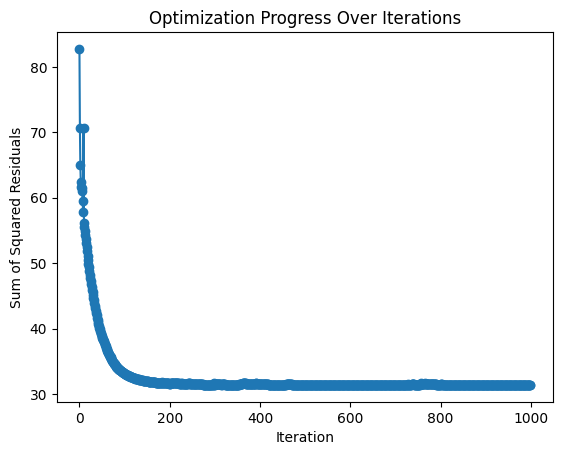

In [10]:
import tensorflow as tf
import matplotlib.pyplot as plt

N = np.array(transactions_per_city).reshape((len(cities), len(categories))).astype(np.float64)

P = np.array([4136344, 4100716, 3991988, 3934088, 4090149, 4141051, 3895117, 3439202,
              3075077, 3025100, 3031855, 2683253, 2187561, 1612948, 1088448, 1394217])  # Population vector
num_age_bins = len(P)

# epsilon = 1e-10  # Small value to avoid division by zero

P_var = tf.Variable(np.random.rand(num_age_bins), dtype=tf.float64)
W = tf.Variable(np.ones([len(categories), num_age_bins]) * 1/num_age_bins, dtype=tf.float64)

# Loss function based on residuals
def loss_fn():
    age_bins = tf.matmul(N, W)
    # epsilon = 1e-10 # Small value to avoid division by zero
    contact_matrix = tf.reduce_sum([
    tf.matmul(tf.reshape(x, (-1, 1)), tf.reshape(1 / x, (1, -1)))
    for x in tf.unstack(age_bins, axis=0)], axis=0)/len(cities)
    K = contact_matrix*(P*P_var)
    K = (K + tf.transpose(K))/2
    estimated_C = K/P
    residuals = estimated_C - contact_others
    return tf.reduce_sum(tf.square(residuals)) +tf.reduce_sum(tf.square(tf.minimum(tf.ones_like(W)-W, tf.zeros_like(W)))) + 2*tf.reduce_sum(tf.square(tf.minimum(W, tf.zeros_like(W)))) +  2*tf.reduce_sum(tf.square(tf.minimum(P_var, tf.zeros_like(P_var)))) + tf.reduce_sum(tf.square(tf.minimum(tf.ones_like(P_var)-P_var, tf.zeros_like(P_var))))


optimizer = tf.optimizers.Adam(learning_rate=0.01)

# Training loop
iteration_residuals = []

# Run the training loop on the GPU
# with tf.device('/GPU:0'):
for step in range(1000):  # Adjust max iterations as needed
    with tf.GradientTape() as tape:
        loss = loss_fn()
    grads = tape.gradient(loss, [W, P_var])

    # Apply gradients
    optimizer.apply_gradients(zip(grads, [W, P_var]))

    iteration_residuals.append(loss.numpy())
    if step % 100 == 0:
        print(f'Step: {step}, Loss: {loss.numpy()}')

# Plot the optimization progress
plt.plot(iteration_residuals, marker='o', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('Sum of Squared Residuals')
plt.title('Optimization Progress Over Iterations')
plt.show()

In [11]:
age_bins = tf.matmul(N, W)
# epsilon = 1e-10
contact_matrix = tf.reduce_sum([
tf.matmul(tf.reshape(x, (-1, 1)), tf.reshape(1 / x, (1, -1)))
for x in tf.unstack(age_bins, axis=0)], axis=0)/len(cities)
K = contact_matrix*(P*P_var)
K = (K + tf.transpose(K))/2
estimated_C = K/P

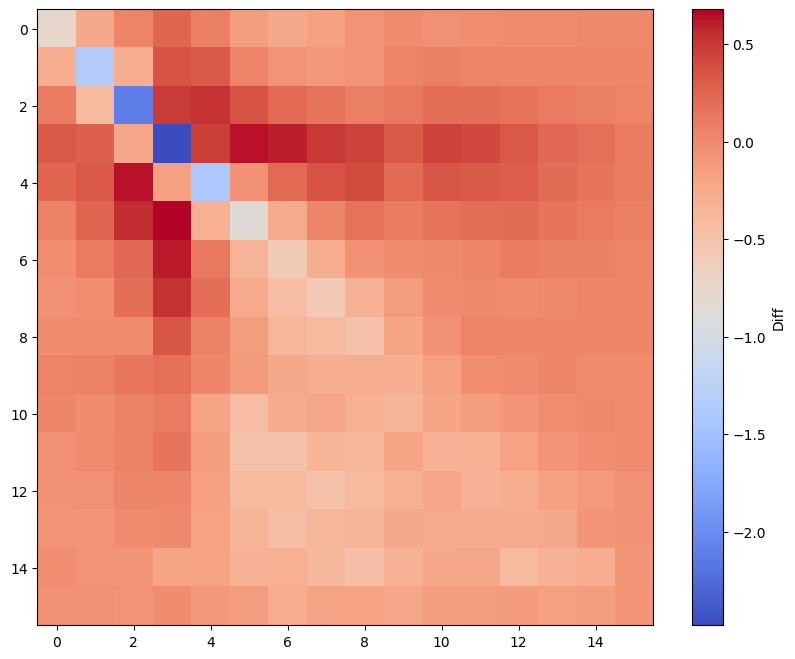

In [12]:
diff = estimated_C - contact_others

plt.figure(figsize=(10, 8))
plt.imshow(diff, cmap = 'coolwarm', interpolation='none')
plt.colorbar(label = 'Diff')

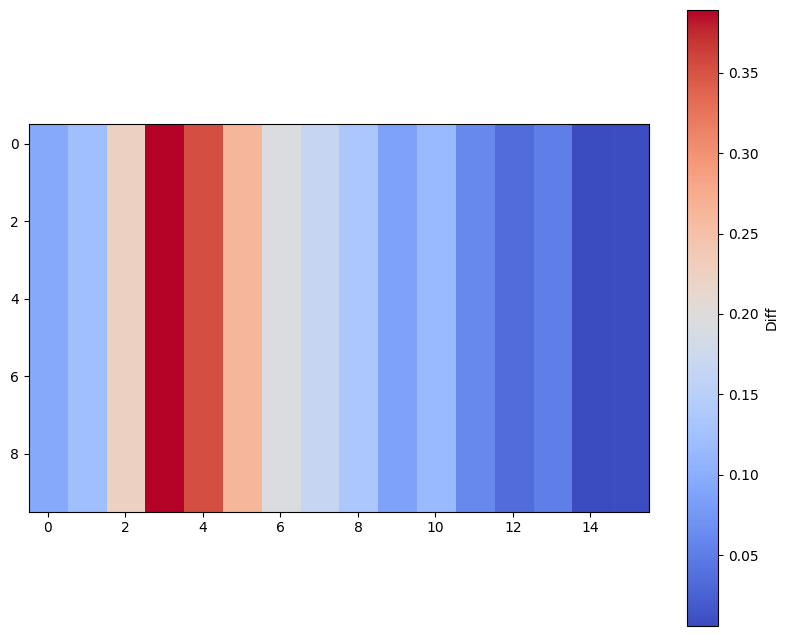

In [13]:
# diff = estimated_C - contact_others

plt.figure(figsize=(10, 8))
plt.imshow(W, cmap = 'coolwarm', interpolation='none')
plt.colorbar(label = 'Diff')

In [14]:
W

<tf.Variable 'Variable:0' shape=(10, 16) dtype=float64, numpy=
array([[0.09433389, 0.1236908 , 0.22353105, 0.38917828, 0.35217605,
        0.26322616, 0.19383107, 0.16504789, 0.13519015, 0.08649681,
        0.11608759, 0.06013611, 0.03446248, 0.05151014, 0.00581461,
        0.00807102],
       [0.0943339 , 0.12369081, 0.2235312 , 0.38917845, 0.35217612,
        0.2632263 , 0.19383109, 0.16504796, 0.13519013, 0.08649681,
        0.11608761, 0.0601361 , 0.03446247, 0.05151013, 0.0058146 ,
        0.00807102],
       [0.09433375, 0.1236906 , 0.22352787, 0.38917456, 0.35217439,
        0.26322299, 0.19383041, 0.16504626, 0.13519067, 0.0864968 ,
        0.11608713, 0.06013626, 0.03446262, 0.05151039, 0.0058147 ,
        0.00807117],
       [0.0943339 , 0.12369081, 0.22353118, 0.38917843, 0.35217611,
        0.26322627, 0.19383109, 0.16504794, 0.13519013, 0.08649681,
        0.1160876 , 0.0601361 , 0.03446246, 0.05151013, 0.0058146 ,
        0.00807102],
       [0.0943339 , 0.12369081, 0.223

In [15]:
# save W in a csv file and make one extra column for categories
# W = W.numpy()
W = pd.DataFrame(W*100)
W['categories'] = categories
W.to_csv('consumption_distribution.csv', index=False)

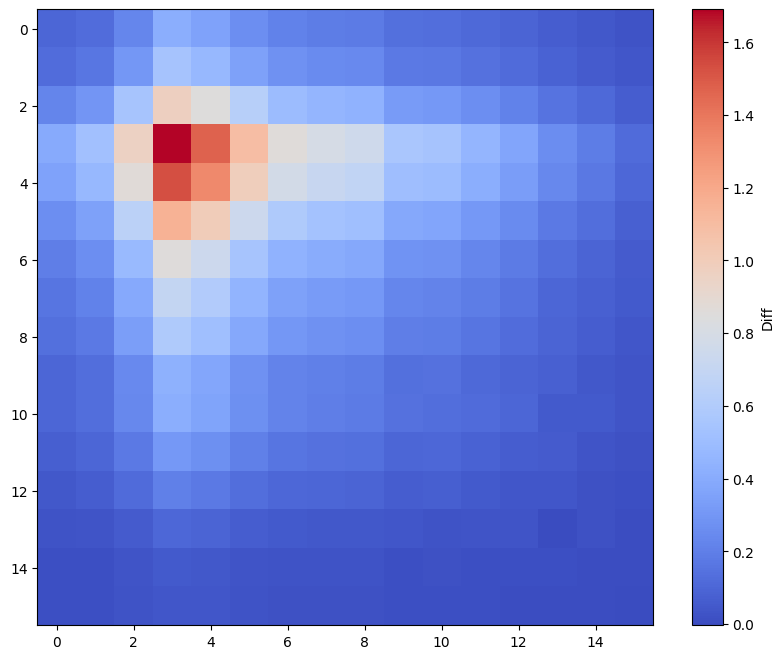

In [16]:
plt.figure(figsize=(10, 8))
plt.imshow(estimated_C, cmap = 'coolwarm', interpolation='none')
plt.colorbar(label = 'Diff')

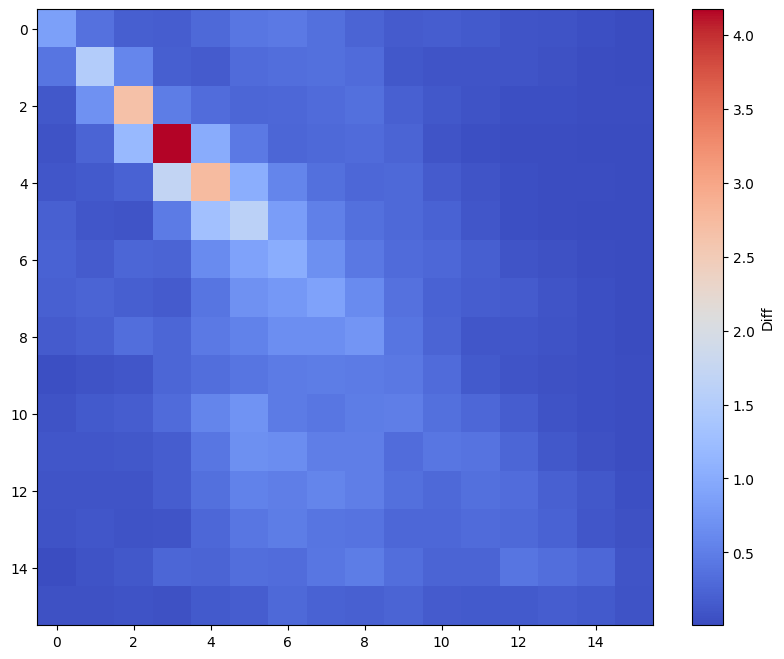

In [45]:
plt.figure(figsize=(10, 8))
plt.imshow(contact_others, cmap = 'coolwarm', interpolation='none')
plt.colorbar(label = 'Diff')

In [17]:
P_var

<tf.Variable 'Variable:0' shape=(16,) dtype=float64, numpy=
array([ 0.09637784,  0.16660364,  0.5509122 ,  1.6909114 ,  1.33267175,
        0.74192492,  0.43630924,  0.32370389,  0.26338517,  0.14134507,
        0.1299012 ,  0.08272605,  0.04140223, -0.00346418,  0.00432023,
        0.00293535])>

In [18]:
# save P_var in a csv file
P_var = pd.DataFrame(P_var.numpy())
P_var.to_csv('fractions_offline.csv', index=False)


In [ ]:
age_groups = ['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75+']
consumption_distribution_raw = pd.read_csv('consumption_distribution.csv')
categories = consumption_distribution_raw['categories'].values
# take the category columns from consumption distribution and build a dictionary consumption_distribution with that as keys and the values should be other columns from the consumption distribution
consumption_distribution = {}
for category in categories:
    consumption_distribution[category] = consumption_distribution_raw[consumption_distribution_raw['categories'] == category].values[0][:-1]
fraction_offline_raw = pd.read_csv('fractions_offline.csv')
fraction_offline = fraction_offline_raw['0'].values
from DP_epidemiology.contact_matrix import get_contact_matrix, get_age_group_count_map
week ="2021-01-05"
start_date = datetime.strptime(week, '%Y-%m-%d')
end_date = datetime.strptime(week, '%Y-%m-%d')
cities = data["merch_postal_code"].astype(str).apply(categorize_city).unique()
counts_per_city = []
for city in cities:
    counts = get_age_group_count_map(data, age_groups, consumption_distribution, start_date, end_date, city)
    counts_per_city.append(list(counts.values()))

[[0.09639499 0.12729793 0.23459957 0.41402875 0.36049844 0.26723058
  0.2115465  0.19405711 0.18478479 0.13980062 0.13994262 0.11607832
  0.09175488 0.0632941  0.04659629 0.03013343]
 [0.12620146 0.16665576 0.30712037 0.54200889 0.47193314 0.3498748
  0.27690055 0.25398197 0.24191404 0.18338147 0.18269152 0.15232642
  0.11995352 0.08292079 0.06101759 0.03935048]
 [0.22641218 0.29897726 0.55092938 0.97226403 0.84656621 0.62773663
  0.49659521 0.45541238 0.43398238 0.33008539 0.3261457  0.27436976
  0.21467129 0.14893569 0.10950967 0.07028655]
 [0.39378387 0.51998497 0.95816226 1.69092516 1.47231897 1.09180417
  0.86359832 0.79193614 0.75478386 0.57468617 0.56636982 0.47778342
  0.37307542 0.25912693 0.19048511 0.12207662]
 [0.35647237 0.47071703 0.86738285 1.53072426 1.33282797 0.98834823
  0.78179446 0.71693113 0.68326978 0.52008892 0.5129196  0.4323717
  0.33779588 0.23455139 0.17243091 0.11055099]
 [0.26753468 0.3533162  0.65117665 1.14924139 1.00064824 0.74162317
  0.58732927 0.5388